# Training and Fine-Tuning BERT for Classification:
## Classfying Goodreads Reviews By Book Genre

By The BERT for Humanists Team
<br></br>

This notebook will demonstrate how users can train and fine-tune a BERT model for classification with the popular HuggingFace `transformers` Python library.

We will fine-tune a BERT model on Goodreads reviews from the [UCSD Book Graph](https://sites.google.com/eng.ucsd.edu/ucsdbookgraph/reviews?authuser=0) with the goal of predicting the genre of the book being reviewed. The genres include:
- poetry
- comics & graphic
- fantasy & paranormal
- history & biography
- mystery, thriller, & crime
- romance
- young adult

<br><br>

## **Import necessary Python libraries and modules**

First, we will import necessary Python libraries and modules — such as `gdown`, for downloading large files from Google Drive (where we will get our UCSD Goodreads reviews), as well as Scikit-Learn (`sklearn`) and PyTorch (`torch`), for various machine learning tools.

In [ ]:
# Basic Python modules
from collections import defaultdict
import random

# For downloading large files from Google Drive
# https://github.com/wkentaro/gdown
import gdown

# For working with gzip files
# https://docs.python.org/3/library/gzip.html
import gzip

# For working with JSON files
import json

# For data manipulation and analysis
import pandas as pd
import numpy as np

# For machine learning tools and evaluation
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# For deep learning
# https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html
import torch

# For plotting and data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
sns.set(style='ticks', font_scale=1.2)

To use the HuggingFace [`transformers` Python library](https://huggingface.co/transformers/installation.html), we will install it with `pip`.

In [ ]:
!pip3 install transformers

     |████████████████████████████████| 2.0MB 14.0MB/s 
     |████████████████████████████████| 890kB 54.0MB/s 
     |████████████████████████████████| 3.2MB 56.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=0f66c3677f619f4ef4cb9a20dc377f48b600516a490115891dfc8c191e1c4e2f
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


Once `transformers` is installed, we will import modules for `DistilBert`, a *distilled* or smaller version of a BERT model that runs more quickly and uses less computing power. This makes it ideal for those just getting started with BERT.

In [ ]:
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments

<br><br>

## **Set parameters and file paths**

In [ ]:
# This is the name of the BERT model that we want to use. We're using DistilBERT to save space (it's a distilled version of the full BERT model), and we're going to use the cased (vs uncased) version.
model_name = 'distilbert-base-cased'  

 # This is the name of the program management system for NVIDIA GPUs. We're going to send our code here.
device_name = 'cuda'       

# This is the maximum number of tokens in any document sent to BERT.
max_length = 512                                                        

# This is the name of the directory where we'll save our model.
cached_model_directory_name = 'distilbert-reviews-genres'  

<br><br>

## **Load and sample Goodreads data**

In this cell, we create a Python dictionary with each genre and the link to the corresponding UCSD Goodreads review data for that genre on Google Drive.

*If you manually click on any of the URLs, you will be able to download the data for that genre. For example, here's the link for poetry: https://drive.google.com/uc?id=1FVD3LxJXRc5GrKm97LehLgVGbRfF9TyO*

In [ ]:
# This is where our target data is hosted on the web. You only need these paths for the book review dataset.

genre_url_dict = {'poetry': 'https://drive.google.com/uc?id=1FVD3LxJXRc5GrKm97LehLgVGbRfF9TyO',
                  'children': 'https://drive.google.com/uc?id=1908GDMdrhDN7sTaI_FelSHxbwcNM1EzR',
                  'comics_graphic': 'https://drive.google.com/uc?id=1V4MLeoEiPQdocCbUHjR_7L9ZmxTufPFe',
                  'fantasy_paranormal': 'https://drive.google.com/uc?id=1THnnmE4XSCvMkGOsqapQr2cJI5amKA6X',
                  'history_biography': 'https://drive.google.com/uc?id=1lDkTzM6zpYU-HGkVAQgsw0dBzik-Zde9',
                  'mystery_thriller_crime': 'https://drive.google.com/uc?id=1ONpyuv0vrtd6iUEp0-zzkKqwpm3njEqi',
                  'romance': 'https://drive.google.com/uc?id=1NpFsDQKBj_lrTzSASfyKbmkSykzN88wE',
                  'young_adult': 'https://drive.google.com/uc?id=1M5iqCZ8a7rZRtsmY5KQ5rYnP9S0bQJVo'}

Next we loop through this dictionary and use `gdown` to download the Goodreads review data for each genre from Google Drive.

In [ ]:
for _genre, _url in genre_url_dict.items():
  gdown.download(_url, _genre + '.json.gz', quiet=False) 

Downloading...
From: https://drive.google.com/uc?id=1FVD3LxJXRc5GrKm97LehLgVGbRfF9TyO
To: /content/poetry.json.gz
49.3MB [00:00, 75.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1908GDMdrhDN7sTaI_FelSHxbwcNM1EzR
To: /content/children.json.gz
172MB [00:02, 83.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1V4MLeoEiPQdocCbUHjR_7L9ZmxTufPFe
To: /content/comics_graphic.json.gz
147MB [00:02, 59.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1THnnmE4XSCvMkGOsqapQr2cJI5amKA6X
To: /content/fantasy_paranormal.json.gz
1.26GB [00:17, 72.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1lDkTzM6zpYU-HGkVAQgsw0dBzik-Zde9
To: /content/history_biography.json.gz
754MB [00:22, 33.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ONpyuv0vrtd6iUEp0-zzkKqwpm3njEqi
To: /content/mystery_thriller_crime.json.gz
610MB [00:15, 39.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1NpFsDQKBj_lrTzSASfyKbmkSykzN88wE
To: /content/romance.json.gz
1.30GB

If you click the file browser icon in the left-hand side bar, you should see that these files have now been download.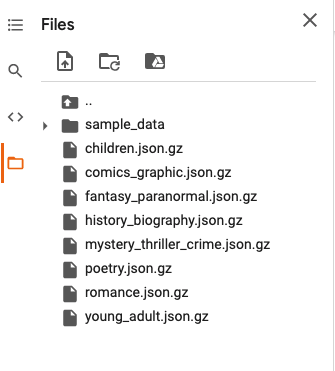 

Next we create a function `load_reviews()`, which will use `gzip` to unzip the downloaded Goodreads review JSON files and `json` to load the JSON files once they're unzipped.

In [ ]:
def load_reviews(file_name,
                 head=None):

    reviews = []
    count = 0

    with gzip.open(file_name) as file:
        for line in file:

            d = json.loads(line)
            count += 1

            _book_id = d['book_id']

            reviews.append(d['review_text'])

            # break if reaches the Nth line
            if (head is not None) and (count > head):
                break

    return reviews

Now we apply the `load_reviews()` function. For each genre, we load and unzip the corresponding `.json.gz` file, e.g., `poetry.json.gz`, then we randomly sample 2000 Goodreads reviews and make a dictionary `genre_reviews_dict` of all these reviews.

In [ ]:
genres = ['poetry', 'children', 'comics_graphic', 'fantasy_paranormal', 'history_biography', 'mystery_thriller_crime', 'romance', 'young_adult']
genre_reviews_dict = {}

for _genre in genres:
  print('Loading ' + _genre + '.json.gz')

  _reviews = load_reviews(_genre + '.json.gz')
  genre_reviews_dict[_genre] = random.sample(_reviews, 2000)

Loading poetry.json.gz
Loading children.json.gz
Loading comics_graphic.json.gz
Loading fantasy_paranormal.json.gz
Loading history_biography.json.gz
Loading mystery_thriller_crime.json.gz
Loading romance.json.gz
Loading young_adult.json.gz


Let's preview a couple of the key-value pairs in `genre_reviews_dict`

children ["This is better than the other ancilary book I've read on the creatures in the Spiderwick novels and has enough content that I wouldn't feel cheated if I bought it. It's still for or obsessive fans only.", "Embarrassingly I've never seen an episode of the X-Files. I've heard how great it is and I know how awesome Gillian Anderson and David Duchovny are. This book though was absolutely fantastic. I loved it! I thought it was cute, the illustrations were wonderful and the ending, god, it was hilarious. Great book and I look forward to more.", 'This book, as all the other books by David Shannon is very funny and rateable. Both parents and their kids will love this.', '(3.5)', 'This one was probably one of my favorites of the whole Harry Potter series. \n J.k. Rowlings writing was awesome', 'Move Over, Rover! is a book that helps remind readers to "read like a detective." It was fun to see the animals piling into the dog house. The predictable refrain was cute and I thought I was
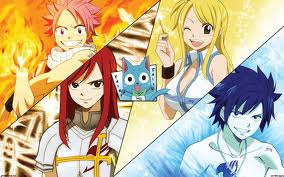

In [ ]:
 for key, value in sorted(genre_reviews_dict.items())[:2]:
    print(key, value)

Here we use `pickle` to save this Python dictionary to a `.pickle` file so we can easily load it later.

*The `pickle` module allows you to save and load Python objects like lists and dictionaries.*

In [ ]:
import pickle

#pickle.dump(genre_reviews_dict, open('genre_reviews_dict.pickle', 'wb'))
genre_reviews_dict = pickle.load(open('genre_reviews_dict.pickle', 'rb'))

<br><br>

## **Split the data into train and test sets**

When training a machine learning model, it is necessary to split your training data into two parts: a "training" set and a "test" set.

We will train our BERT model on the "training" set of Goodreads reviews and then we will evaluate how well it is performing by running it on the "test" set of Goodreads reviews that the model has never seen before.

If you plan to tune the hyperparameters, you should also create a "validation" set for tuning, and only use the "test" set once, at the end of all tuning.

In [ ]:
train_texts = []
train_labels = []

test_texts = []
test_labels = []

for _genre, _reviews in genre_reviews_dict.items():

  _reviews = random.sample(_reviews, 1000) # Use a very small set as an example.
  
  for _review in _reviews[:800]:
    train_texts.append(_review)
    train_labels.append(_genre)
  for _review in _reviews[800:]:
    test_texts.append(_review)
    test_labels.append(_genre)

Show how many Goodreads reviews and labels we have in each category: 6400 training reviews, 6400 training labels (genres), 1600 test reviews, 1600 test labels (genre)

In [ ]:
len(train_texts), len(train_labels), len(test_texts), len(test_labels)

(6400, 6400, 1600, 1600)

Heere's an example of a training label and review:

In [ ]:
train_labels[0], train_texts[0]

('poetry',
 'A beautiful life one will find if living by these words of wisdom. A book to provoke spiritual thinking.')

<br><br>

## **Run a baseline model (Logistic Regression)**

Here we train and evaluate a simple TF-IDF baseline model using logistic regression.

We find better-than-random performance, even for a very small dataset.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

In [ ]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_texts)
X_test = vectorizer.transform(test_texts)

We run a Logistic Regression model from Scikit-learn on the Goodreads training data and then we make predictions on our Goodreads review test set.

In [ ]:
model = LogisticRegression(max_iter=1000).fit(X_train, train_labels)
predictions = model.predict(X_test)

We can use Scikit-learn's `classification_report` function to evaluate how well the Logistic Regression model's predictions match up with the true labels for the Goodreads reviews.

In [ ]:
print(classification_report(test_labels, predictions))

                        precision    recall  f1-score   support

              children       0.53      0.55      0.54       200
        comics_graphic       0.54      0.59      0.56       200
    fantasy_paranormal       0.39      0.33      0.36       200
     history_biography       0.45      0.39      0.42       200
mystery_thriller_crime       0.48      0.44      0.46       200
                poetry       0.57      0.69      0.63       200
               romance       0.41      0.43      0.42       200
           young_adult       0.36      0.35      0.35       200

              accuracy                           0.47      1600
             macro avg       0.47      0.47      0.47      1600
          weighted avg       0.47      0.47      0.47      1600



<br><br>

## **Encode data for BERT**

We're going to transform our training texts and labels into a format that BERT (via Huggingface and PyTorch) will understand. This is called *encoding* the data.

Here are the steps we need to follow:

1. The labels — in this case, Goodreads genres — need to be turned into integers rather than strings.

2. The texts — in this case, Goodreads reviews — need to be truncated if they're more than 512 tokens or padded if they're fewer than 512 tokens. The tokens, or words in the texts, also need to be separated into "word pieces" and matched to their embedding vectors.

3. We need to add special tokens to help BERT:
    - [CLS] — Start token of every document
    - [SEP] — Separator between each sentence 
    - [PAD] — Padding at the end of the document as many times as necessary, up to 512 tokens
    - &#35;&#35; — Start of a "word piece" 

4. Finally, we'll combine the encoded texts and labels into a custom Torch dataset object.


| BERT special token | Explanation |
| --------------| ---------|
| [CLS] | Start token of every document. |
| [SEP] | Separator between each sentence |
| [PAD] | Padding at the end of the document as many times as necessary, up to 512 tokens |
|  &#35;&#35; | Start of a "word piece" |

Here we will load `DistilBertTokenizerFast` from HuggingFace library, which will help us transform and encode the texts and labels so they can be used with BERT.

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name) # The model_name needs to match our pre-trained model.

Here we will transform our labels, or Goodreads genres, into integers. So we take the unique labels, and then we make a dictionary that associates each label/tag with an integer.

**Note:** HuggingFace documentation sometimes refers to "labels" as "tags" but these are the same thing. We use "labels" throughout this notebook for clarity.

In [ ]:
unique_labels = set(label for label in train_labels)
label2id = {label: id for id, label in enumerate(unique_labels)}
id2label = {id: label for label, id in label2id.items()}

In [ ]:
label2id.keys()

dict_keys(['romance', 'mystery_thriller_crime', 'poetry', 'history_biography', 'comics_graphic', 'fantasy_paranormal', 'young_adult', 'children'])

In [ ]:
id2label.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7])

The `tokenizer()` will break word tokens into word pieces, truncate to 512 tokens, and add padding and special BERT tokens.

In [ ]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_length)
test_encodings  = tokenizer(test_texts, truncation=True, padding=True, max_length=max_length)

train_labels_encoded = [label2id[y] for y in train_labels]
test_labels_encoded  = [label2id[y] for y in test_labels]

**Examine a Goodreads review in the training set after encoding**

In [ ]:
' '.join(train_encodings[0].tokens[0:100])

'[CLS] A beautiful life one will find if living by these words of wisdom . A book to pro ##voke spiritual thinking . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

**Examine a Goodreads review in the test set after encoding**

In [ ]:
' '.join(test_encodings[0].tokens[0:100])

'[CLS] 1 y ##n k ##ht ##b z m ##hm ##try ##n k ##ht ##b ##hy r ##yl ##kh ##h s ##t , shy ##d br ##y m ##n m ##hm ##tr z s ##h ` r ##hs ##h . shy ##d g ##r k ##ht ##b < < nm ##hh ##y ##y b ##h s ##h ` r j ##wn > > n ##b ##w ##d , b y ##n k ##ht ##b ash ##n nm ##ys ##h ##d ##m . d ##r m ##q ##d ##m ##h n ##tl k ##hn ##l ##ry br k ##ht ##b <'

**Examine the training labels after encoding**

In [ ]:
set(train_labels_encoded)

{0, 1, 2, 3, 4, 5, 6, 7}

**Examine the test labels after encoding**

In [ ]:
set(test_labels_encoded)

{0, 1, 2, 3, 4, 5, 6, 7}

<br><br>

## **Make a custom Torch dataset**

Here we use the custom Torch `MyDataSet` class to make a `train_dataset` object from  the `train_encodings` and `train_labels_encoded`. We also make a `test_dataset` object from `test_encodings`, and `test_labels_encoded`.

In [ ]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
        

train_dataset = MyDataset(train_encodings, train_labels_encoded)
test_dataset = MyDataset(test_encodings, test_labels_encoded)

**Examine a Goodreads review in the Torch `training_dataset` after encoding**

In [ ]:
' '.join(train_dataset.encodings[0].tokens[0:100])

'[CLS] A beautiful life one will find if living by these words of wisdom . A book to pro ##voke spiritual thinking . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

**Examine a Goodreads review in the Torch `test_dataset` after encoding**

In [ ]:
' '.join(test_dataset.encodings[1].tokens[0:100])

"[CLS] Re ##mark ##ably o ##bs ##er ##vant poems describing sights and events from the poet ' s travels in Burma ##n , Indonesia , Malaysia , Thailand , Cambodia and V ##iet Nam . Some of her most compelling insights have to do with the race , class and gender politics of a middle - class white woman working , touring and writing in these places - - especially as her observing turns both outward and inward . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]"

<br><br>

## **Load pre-trained BERT model**

Here we loaded a pre-trained BERT model. 

**Note:** If you decide to repeat fine-tuning after already running the following cells, make sure that you re-run this cell to re-load the original pre-trained model before fine-tuning again.

In [ ]:
# The model_name needs to match the name used for the tokenizer above.
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=len(id2label)).to(device_name)

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier

<br><br>

## **Set the BERT fine-tuning parameters**

These are the arguments we'll set in the HuggingFace TrainingArguments objects, which we'll then pass to the HuggingFace Trainer object. There are many more possible arguments, but here we highlight the basics and some common gotchas.

| Parameter | Explanation |
|-----------| ------------|
| num_train_epochs | total number of training epochs (how many times to pass through the entire dataset) |
| per_device_train_batch_size | batch size per device during training |
| per_device_eval_batch_size |  batch size for evaluation |
|  warmup_steps |  number of warmup steps for learning rate scheduler (set lower because of small dataset size) |
| weight_decay | strength of weight decay (reduces size of weights, like regularization) |
| output_dir | output directory for the fine-tuned model and configuration files |
| logging_dir | directory for storing logs |
| logging_steps | how often to print logging output (so that we can stop training early if the loss isn't going down) |
| evaluation_strategy | evaluate while training so that we can see the accuracy going up |

In [ ]:
training_args = TrainingArguments(
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=20,   # batch size for evaluation
    learning_rate=5e-5,              # initial learning rate for Adam optimizer
    warmup_steps=100,                 # number of warmup steps for learning rate scheduler (set lower because of small dataset size)
    weight_decay=0.01,               # strength of weight decay
    output_dir='./results',          # output directory
    logging_dir='./logs',            # directory for storing logs
    logging_steps=100,                # number of steps to output logging (set lower because of small dataset size)
    evaluation_strategy='steps',     # evaluate during fine-tuning so that we can see progress
)

<br><br>

## **Fine-tune the BERT model**

First, we define a custom evaluation function that returns the accuracy. You could modify this function to return precision, recall, F1, and/or other metrics.

In [ ]:
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  acc = accuracy_score(labels, preds)
  return {
      'accuracy': acc,
  }

Then we create a HuggingFace Trainer object using the TrainingArguments object that we created above. We also send our `compute_metrics` function to the Trainer object, a long with our test and train datasets.

**Note:** This is what we've been aiming for this whole time! All the work of tokenizing, creating datasets, and setting the training arguments was for this cell.

In [ ]:
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset,           # evaluation dataset
    compute_metrics=compute_metrics      # our custom evaluation function 
)

Time to finally fine-tune! 

Be patient; if you've set everything in Colab to use GPUs, then it should only take a minute or two to run, but if you're running on CPU, it can take hours.

After every 10 steps (as we specified in the TrainingArguments object), the trainer will output the current state of the model, including the training loss, validation ("test") loss, and accuracy (from our `compute_metrics` function).

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Runtime,Samples Per Second
100,2.013100,1.784711,0.345625,13.833300,115.663000
200,1.544900,1.491088,0.476250,13.830400,115.687000
300,1.453200,1.415791,0.496250,13.844200,115.572000
400,1.378500,1.360293,0.512500,13.836800,115.633000
500,1.092000,1.340557,0.519375,13.844800,115.566000
600,1.098300,1.317340,0.530000,13.838700,115.618000
700,1.046000,1.333464,0.541875,13.828800,115.700000
800,1.043600,1.323472,0.535000,13.846400,115.553000
900,0.761000,1.371435,0.535625,13.842100,115.590000
1000,0.732100,1.391430,0.535000,13.836700,115.635000


TrainOutput(global_step=1200, training_loss=1.1255325317382812, metrics={'train_runtime': 699.3362, 'train_samples_per_second': 1.716, 'total_flos': 3880313841254400.0, 'epoch': 3.0, 'init_mem_cpu_alloc_delta': 49217, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 18306, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 294071, 'train_mem_gpu_alloc_delta': 792468992, 'train_mem_cpu_peaked_delta': 90104820, 'train_mem_gpu_peaked_delta': 6540809216})

<br><br>

## **Save fine-tuned model**

The following cell will save the model and its configuration files to a directory in Colab. To preserve this model for future use, you should download the model to your computer.

In [ ]:
trainer.save_model(cached_model_directory_name)

<br><br>

## **Evaluate fine-tuned model**

(Optional) If you've already fine-tuned and saved the model, you can reload it using the following line. You don't have to run fine-tuning every time you want to evaluate.

In [ ]:
# trainer = DistilBertForSequenceClassification.from_pretrained(cached_model_directory_name)

The following function of the Trainer object will run the built-in evaluation, including our `compute_metrics` function.

In [ ]:
trainer.evaluate()

{'epoch': 3.0,
 'eval_accuracy': 0.54125,
 'eval_loss': 1.382175087928772,
 'eval_mem_cpu_alloc_delta': 127767,
 'eval_mem_cpu_peaked_delta': 46945,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_gpu_peaked_delta': 723764736,
 'eval_runtime': 13.8587,
 'eval_samples_per_second': 115.451}

But we might want to do more fine-grained analysis of the model, so we extract the predicted labels.

In [ ]:
predicted_results = trainer.predict(test_dataset)

In [ ]:
predicted_results.predictions.shape

(1600, 8)

In [ ]:
predicted_labels = predicted_results.predictions.argmax(-1)

In [ ]:
predicted_labels.shape

(1600,)

In [ ]:
predicted_labels = predicted_labels.flatten().tolist()

In [ ]:
len(predicted_labels)

1600

In [ ]:
print(classification_report(test_labels, 
                            [id2label[l] for l in predicted_labels]))

                        precision    recall  f1-score   support

              children       0.59      0.67      0.63       200
        comics_graphic       0.62      0.65      0.63       200
    fantasy_paranormal       0.41      0.40      0.40       200
     history_biography       0.59      0.53      0.56       200
mystery_thriller_crime       0.53      0.48      0.51       200
                poetry       0.73      0.72      0.73       200
               romance       0.48      0.44      0.46       200
           young_adult       0.38      0.45      0.41       200

              accuracy                           0.54      1600
             macro avg       0.54      0.54      0.54      1600
          weighted avg       0.54      0.54      0.54      1600



<br><br>

# Pull out correct and incorrect classifications for examination

Let's use our predicted labels for some analysis!

First, let's print out some example predictions that were correct.

In [ ]:
for _true_label, _predicted_label, _text in random.sample(list(zip(test_labels, [id2label[l] for l in predicted_labels], test_texts)), 20):
  if _true_label == _predicted_label:
    print('LABEL:', _true_label)
    print('REVIEW TEXT:', _text[:100], '...')
    print()

LABEL: children
REVIEW TEXT: We have already read this book and shared it with others more times than any other book this past we ...

LABEL: poetry
REVIEW TEXT: This collection plays with the idea of "numbered days" in more ways than one. It explores the theme  ...

LABEL: young_adult
REVIEW TEXT: There is no words to describe it! it was amazing, best book I've ever read! okay just stop reading t ...

LABEL: comics_graphic
REVIEW TEXT: Negima! Magister Negi Magi, Vol. 3 by Ken Akamatsu (2004) ...

LABEL: young_adult
REVIEW TEXT: ONE DAY THIS BOOK WILL COME OUT. ONE DAY. ...

LABEL: children
REVIEW TEXT: Fuddles is a pampered feline, who dreams of living a life of adventure. Unfortunately, he gets his c ...

LABEL: romance
REVIEW TEXT: this was my first book by Anne Marsh & I really enjoyed it. Former navy seal Rio can't keep his eyes ...

LABEL: mystery_thriller_crime
REVIEW TEXT: Terrific romantic suspense. ...

LABEL: poetry
REVIEW TEXT: Hsnan 
 , 
 'n knt bHwl 'qtbs 'y Hj@ 'ktbh fy

Now let's print out some misclassifications.

In [ ]:
for _true_label, _predicted_label, _text in random.sample(list(zip(test_labels, [id2label[l] for l in predicted_labels], test_texts)), 20):
  if _true_label != _predicted_label:
    print('TRUE LABEL:', _true_label)
    print('PREDICTED LABEL:', _predicted_label)
    print('REVIEW TEXT:', _text[:100], '...')
    print()

TRUE LABEL: fantasy_paranormal
PREDICTED LABEL: mystery_thriller_crime
REVIEW TEXT: I love the wheel of time series and I've been reading the series since the 90's and I've reread thes ...

TRUE LABEL: children
PREDICTED LABEL: comics_graphic
REVIEW TEXT: yang paling oke dari buku-buku Roald Dahl yang udah kubaca sejauh ini...... ...

TRUE LABEL: comics_graphic
PREDICTED LABEL: children
REVIEW TEXT: Too adorable. ...

TRUE LABEL: fantasy_paranormal
PREDICTED LABEL: comics_graphic
REVIEW TEXT: I picked this up because I enjoy Ouran High School Host Club. The characters weren't as engaging as  ...

TRUE LABEL: poetry
PREDICTED LABEL: young_adult
REVIEW TEXT: I'm torn. This book is a collection of writings that waver from drivel to inspired prose. The good s ...

TRUE LABEL: fantasy_paranormal
PREDICTED LABEL: young_adult
REVIEW TEXT: Sarah J. Mass is very very very cruel. 
 I am dead. I am nothing. 
 I would rather die or even bette ...

TRUE LABEL: poetry
PREDICTED LABEL: comics_graphic

Finally, let's create some heatmaps to examine misclassification patterns. We could use these patterns to think about similarities and differences between genres, according to book reviewers.

In [ ]:
genre_classifications_dict = defaultdict(int)
for _true_label, _predicted_label in zip(test_labels, [id2label[l] for l in predicted_labels]):
  genre_classifications_dict[(_true_label, _predicted_label)] += 1
  
dicts_to_plot = []
for (_true_genre, _predicted_genre), _count in genre_classifications_dict.items():
  dicts_to_plot.append({'True Genre': _true_genre,
                        'Predicted Genre': _predicted_genre,
                        'Number of Classifications': _count})
  
df_to_plot = pd.DataFrame(dicts_to_plot)
df_wide = df_to_plot.pivot_table(index='True Genre', 
                                 columns='Predicted Genre', 
                                 values='Number of Classifications')

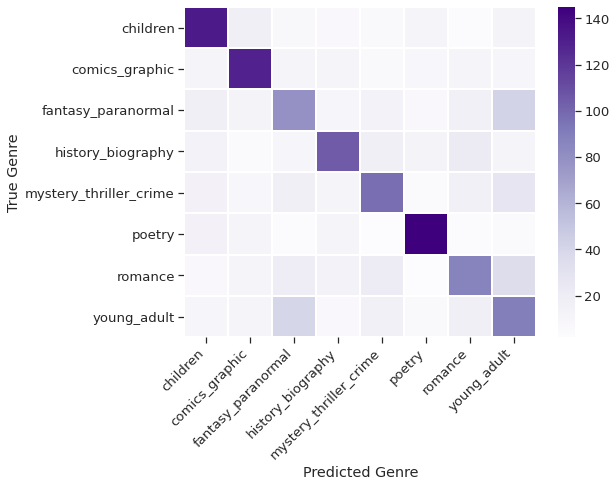

In [ ]:
plt.figure(figsize=(9,7))
sns.set(style='ticks', font_scale=1.2)
sns.heatmap(df_wide, linewidths=1, cmap="Purples")    
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
genre_classifications_dict = defaultdict(int)
for _true_label, _predicted_label in zip(test_labels, [id2label[l] for l in predicted_labels]):
  if _true_label != _predicted_label:
    genre_classifications_dict[(_true_label, _predicted_label)] += 1
  
dicts_to_plot = []
for (_true_genre, _predicted_genre), _count in genre_classifications_dict.items():
  dicts_to_plot.append({'True Genre': _true_genre,
                        'Predicted Genre': _predicted_genre,
                        'Number of Classifications': _count})
  
df_to_plot = pd.DataFrame(dicts_to_plot)
df_wide = df_to_plot.pivot_table(index='True Genre', 
                                 columns='Predicted Genre', 
                                 values='Number of Classifications')

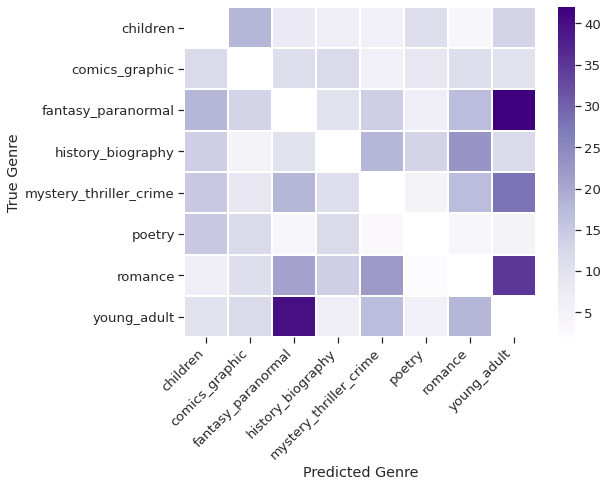

In [ ]:
plt.figure(figsize=(9,7))
sns.set(style='ticks', font_scale=1.2)
sns.heatmap(df_wide, linewidths=1, cmap="Purples")    
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

There's much more you can do with your own dataset and labels! Classification can be used to apply a small set of labels across a big dataset; to explore misclassifications to better understand users; and much more! We hope you'll use this tutorial in all kinds of creative ways.